In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.callbacks import TensorBoard
import shutil
import os
import datetime

# The purpose of this notebook is to practice on building neural netwrok for predicting the amount of taxi_fare based on distance traveled. The data used were from Google Cloud public dataset.

In [2]:
!ls -l ../data/*.csv

-rw-rw-r-- 1 shiya shiya 123590 Dec  5 19:36 ../data/taxi-test.csv
-rw-rw-r-- 1 shiya shiya 579055 Dec  5 19:36 ../data/taxi-train.csv
-rw-rw-r-- 1 shiya shiya 123114 Dec  5 19:36 ../data/taxi-valid.csv


In [3]:
train_pd = pd.read_csv('../data/taxi-train.csv')
train_pd
#Checking the format of data. Missing feature names!

,11.3,2011-01-28 20:42:59 UTC,-73.999022,40.739146,-73.990369,40.717866,1,0
0,7.7,2011-06-27 04:28:06 UTC,-73.987443,40.729221,-73.979013,40.758641,1,1
1,10.5,2011-04-03 00:54:53 UTC,-73.982539,40.735725,-73.954797,40.778388,1,2
2,16.2,2009-04-10 04:11:56 UTC,-74.001945,40.740505,-73.913850,40.758559,1,3
3,33.5,2014-02-24 18:22:00 UTC,-73.993372,40.753382,-73.860900,40.732897,2,4
4,6.9,2011-12-10 00:25:23 UTC,-73.996237,40.721848,-73.989416,40.718052,1,5
...,...,...,...,...,...,...,...,...
7327,4.5,2014-10-06 15:16:00 UTC,-73.970435,40.764617,-73.962507,40.775907,1,7328
7328,16.9,2012-03-04 00:57:00 UTC,-73.985456,40.758156,-74.008113,40.704856,1,7329
7329,9.0,2013-04-01 08:10:33 UTC,-73.994211,40.750970,-73.971693,40.753818,1,7330
7330,11.0,2015-05-09 10:09:38 UTC,-73.963676,40.761753,-73.988770,40.727432,1,7331


In [4]:
COLUMNS = ['fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key']

#Label fare amount for prediction.
LABELS = 'fare_amount'
#Features to be removed
UNWANTED_COLUMNS = ['pickup_datetime', 'key']
DEFAULTS = [[0.0], ['na'],[0.0], [0.0], [0.0],[0.0],[0.0],['na']]

In [5]:
#Function used to cleaning data, and seperating features and label.
def dataClean(row_data):
    label_column = row_data.pop(LABELS)
    feature_columns = row_data
    
    for unwanted in UNWANTED_COLUMNS:
        feature_columns.pop(unwanted)
    
    return feature_columns, label_column

In [6]:
#Creating a generator later used in model.fit() method
def createDataset(pattern, batch_size, mode = 'eval'):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, COLUMNS, DEFAULTS)
    #Cleaning data
    dataset = dataset.map(dataClean)
    
    #Shuffle training data, since we are gonna use batch size of 1000,
    #the buffer size was set accordingly.
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=1000).repeat()
    dataset = dataset.prefetch(1)
    return dataset

In [7]:
input_features = ['pickup_longitude', \
                  'pickup_latitude', \
                  'dropoff_latitude', \
                  'dropoff_longitude']
feature_dict = { names: tf.feature_column.numeric_column(names) \
                for names in input_features}
feature_dict

{'pickup_longitude': NumericColumn(key='pickup_longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'pickup_latitude': NumericColumn(key='pickup_latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'dropoff_latitude': NumericColumn(key='dropoff_latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'dropoff_longitude': NumericColumn(key='dropoff_longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)}

In [8]:
#Creating model of neural network
Model = Sequential([DenseFeatures(feature_columns = feature_dict.values()), \
                    Dense(32, 'relu', 'h1'), \
                    Dense(8, 'relu', 'h2'), \
                    Dense(1, 'linear', 'output')])
type(Model)

keras.engine.sequential.Sequential

In [9]:
#Custom metric used for testing the model
def rmse(y_pred, y_true):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [10]:
Model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])

In [11]:
%time 
NUM_EPOCH = 50
TRAIN_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5
NUM_EVAL_EXAMPLES = 10000
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EPOCH)
LOGDIR = "./taxi_trained"

#Defining data generated
train_data = createDataset('../data/taxi-train.csv', TRAIN_BATCH_SIZE, mode = 'train')
#Validation data was set to take 10 set of data of batch size 1000
eval_data = createDataset('../data/taxi-valid.csv', 1000).take(10)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [12]:
#Model training
history = Model.fit(steps_per_epoch = 1, \
          x = train_data, \
          validation_data = eval_data, \
          callbacks=[TensorBoard(LOGDIR)], \
          epochs = NUM_EPOCH) 

Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
1/1 [==============================] - ETA: 0s - loss: 379.6956 - rmse: 19.4858 - mse: 379.6956WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'collections.OrderedDict'> input: OrderedDict([('pickup_longitude', <tf.Tensor 'IteratorGetNext:4' shape=(1000,) dtype=float32>), ('pickup_latitude', <tf.Tensor 'IteratorGetNext:3' shape=(1000,) dtype=float32>), ('dropoff_longitude', <tf.Tensor 'IteratorGetNext:1' shape=(1000,) dtype=float32>), ('dropoff_latitude', <tf.Tensor 'IteratorGetNext:0' shape=(1000,) dtype=float32>), ('passenger_count', <tf.Tensor 'IteratorGetNext:2' shape=(1000,) dtype=float32>)])
Consider rewriting this model with the Functional API.
1/1 [==============================] - 14s 14s/step - loss: 379.6956 - rmse: 19.4858 - mse: 379.6956 - val_loss: 402.0830 - val_rmse: 20.0447 - val_mse: 40

In [13]:
print(eval_data)

<TakeDataset shapes: (OrderedDict([(pickup_longitude, (1000,)), (pickup_latitude, (1000,)), (dropoff_longitude, (1000,)), (dropoff_latitude, (1000,)), (passenger_count, (1000,))]), (1000,)), types: (OrderedDict([(pickup_longitude, tf.float32), (pickup_latitude, tf.float32), (dropoff_longitude, tf.float32), (dropoff_latitude, tf.float32), (passenger_count, tf.float32)]), tf.float32)>


In [14]:
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features (DenseFeatur  multiple                 0         
 es)                                                             
                                                                 
 dense (Dense)               multiple                  160       
                                                                 
 dense_1 (Dense)             multiple                  264       
                                                                 
 dense_2 (Dense)             multiple                  9         
                                                                 
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In [15]:
print(history.history.keys())

dict_keys(['loss', 'rmse', 'mse', 'val_loss', 'val_rmse', 'val_mse'])


In [16]:
#Actual loss vs predicted loss
LOSS_PLT = pd.DataFrame(history.history)[['loss', 'val_loss']]
LOSS_PLT.head(10)

,loss,val_loss
0,379.695648,402.083008
1,327.061676,382.306458
2,319.981812,365.225098
3,353.723633,344.140625
4,282.655426,334.004364
5,296.742249,313.682861
6,321.138550,302.231354
7,288.176605,288.345306
8,240.698257,274.369781
9,239.020538,263.639893


<AxesSubplot:>

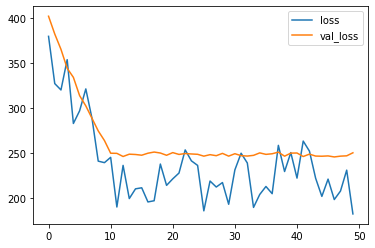

In [17]:
#Visualization of loss vs predict loss
LOSS_PLT.plot()

<AxesSubplot:>

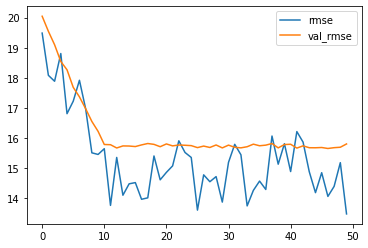

In [18]:
pd.DataFrame(history.history)[['rmse', 'val_rmse']].plot()

In [19]:
#Testing prediction
Model.predict(x={"pickup_longitude": tf.convert_to_tensor([-73.982683]),
                 "pickup_latitude": tf.convert_to_tensor([40.742104]),
                 "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
                 "dropoff_latitude": tf.convert_to_tensor([40.755174]),
                 "passenger_count": tf.convert_to_tensor([3.0])},
              steps=1)

Consider rewriting this model with the Functional API.


array([[0.04705069]], dtype=float32)

In [20]:
#Saving model to external files
output_dir = './export/savedmodels'
shutil.rmtree(output_dir, ignore_errors = True)
output_path = os.path.join(output_dir, 'taxi_fare', str(datetime.datetime.now()))
tf.saved_model.save(Model, output_path)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
INFO:tensorflow:Assets written to: ./export/savedmodels/taxi_fare/2021-12-13 15:32:43.104266/assets
